# WDL 2021 - Final

# Introduction

# Data pre-processing

## Import libraries and customize seaborn

In [47]:
import pandas as pd
import numpy as np
import time
import datetime
import pickle
import requests
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from math import floor, sin, cos, sqrt, atan2, radians, asin
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers.convolutional import Conv1D, MaxPooling1D
#from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
#import folium
from itertools import combinations
#import networkx as nx

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

pd.set_option('display.max_rows', 100)
sns.set_theme(style="whitegrid")
fig_dim = (16,9)

base = 'Data/noise_data/csv_format'
#base = '/home/bsilva/Desktop'
#base = r'C:\Users\Carolina Alves\OneDrive - Universidade de Aveiro\WDL competition\Stage 3/'

from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

import warnings
warnings.filterwarnings('ignore')

## Auxiliar functions

In [11]:
# bar plot function
def bar_plot(_x, _y, _data):
    fig, axs = plt.subplots(figsize=fig_dim)
    axs = sns.barplot(x=_x, y=_y, data=_data)
    plt.xticks(rotation=90)
    plt.draw()
    
# performs the encoding of categorical features to ordinal numbers
def encode_categorical_features(_df, features):
    df = _df.copy()
    enc = OrdinalEncoder()
    df[features] = enc.fit_transform(df[features]).astype(int)
    
    return enc, df

def correlation_matrix (df):
    cor = df.corr()
    fig,ax = plt.subplots(figsize=(12,12))
    sns.heatmap(cor, annot=True)

## Loading the dataset

In [3]:
# Opening and saving the original dataset
# We converted the file from csv to binary in order to read it faster
# You do not need to run this cell
def saving_dfs_as_binary_files(base):
    
    df = pd.read_csv(base+'/'+"san_salvario_" + str(2016) + ".csv", sep=";")
    
    for year in range(2017, 2020):
        _df_year = pd.read_csv(base+'/'+"san_salvario_" + str(year) + ".csv", sep=";")
        df = pd.concat([df, _df_year])
    
    pickle.dump(df, open(base+'/'+"df_raw", "wb"))
        
saving_dfs_as_binary_files(base)

In [68]:
import math

sensors = ['C1', 'C2', 'C3', 'C4', 'C5']

def aux(val):
    return pow(10, val/10)


# Opening data
def get_sensors_data(sensors):
    df = pickle.load(open(base+'/'+"df_raw", "rb" ))

    for col in sensors:
        df[col] = df[col].str.replace(',', '.').astype(float)

    df['date'] = pd.to_datetime(df["Data"] + df['Ora'] , format='%d-%m-%Y%H:00')
    df['year'] = df["date"].dt.year
    df['month'] = df["date"].dt.month
    df['day'] = df["date"].dt.day
    df['hour'] = df['Ora'].str.replace(':00', '').astype(int)
    
    df = df.set_index('date')
    
    df['C1_temp'] = pow(10, df['C1']/10)
    df['C2_temp'] = pow(10, df['C2']/10)
    df['C3_temp'] = pow(10, df['C3']/10)
    df['C4_temp'] = pow(10, df['C4']/10)
    df['C5_temp'] = pow(10, df['C5']/10)
    
    # e se tiver valores nulos??
    df['C_avg'] = df[['C1_temp', 'C2_temp', 'C3_temp', 'C4_temp', 'C5_temp']].sum(axis = 1).div(5)
    df['C_avg'] = 10*np.log10(df['C_avg'])
    
    #return df
    return df[['year', 'month', 'day', 'hour', 'C1', 'C2', 'C3', 'C4', 'C5', 'C_avg']]
    
df = get_sensors_data(sensors)
df

,year,month,day,hour,C1,C2,C3,C4,C5,C_avg
date,,,,,,,,,,
2016-06-01 00:00:00,2016,6,1,0,61.1,58.8,63.7,60.4,60.2,61.162532
2016-06-01 01:00:00,2016,6,1,1,57.2,56.1,60.4,57.7,58.4,58.207715
2016-06-01 02:00:00,2016,6,1,2,52.5,53.4,52.9,56.7,56.5,54.788571
2016-06-01 03:00:00,2016,6,1,3,50.6,46.6,45.7,47.9,55.6,50.951102
2016-06-01 04:00:00,2016,6,1,4,47.4,46.2,45.1,45.8,56.8,51.110268
...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,2019,12,31,19,62.2,59.8,60.3,NaN,NaN,58.675970
2019-12-31 20:00:00,2019,12,31,20,59.4,59.7,55.9,NaN,NaN,56.421207
2019-12-31 21:00:00,2019,12,31,21,59.2,61.0,56.0,NaN,NaN,56.970194


In [70]:
df.shape

(31416, 10)

## Data types, uniques, NaNs and Zeros information 

**Checking type of data, number of unique values and the presence of missing values and zeros**

In [71]:
def eda_to_df(df):
    header="+" + ("-"*112) + "+"
    form = "|{:^18s}|{:^17s}|{:^10s}|{:^10s}|{:^15s}|{:^10s}|{:^15s}|{:^10s}|"
    print(header)
    print(form.format("Column", "Type", "Uniques", "NaN?", "Number of NaN" ,"%NaN", "Number of 0s" ,"%0s"))
    print(header)
    for col in df.columns:
        print(form.format(str(col), # Column
                          str(df[col].dtypes), # Type
                          str(len(df[col].unique())), # Uniques
                          str(df[col].isnull().values.any()), # NaN?
                          str(df[col].isnull().sum()), # Number of NaNs
                          str(round(((df[col].isnull().sum())/len(df[col]))*100,5)), # %NaN
                          str((df[col] == 0).sum()), # Number of 0's
                          str(round((((df[col] == 0).sum())/len(df[col]))*100,5))) # %0's
              )
    print(header)    

eda_to_df(df)

+----------------------------------------------------------------------------------------------------------------+
|      Column      |      Type       | Uniques  |   NaN?   | Number of NaN |   %NaN   | Number of 0s  |   %0s    |
+----------------------------------------------------------------------------------------------------------------+
|       year       |      int64      |    4     |  False   |       0       |   0.0    |       0       |   0.0    |
|      month       |      int64      |    12    |  False   |       0       |   0.0    |       0       |   0.0    |
|       day        |      int64      |    31    |  False   |       0       |   0.0    |       0       |   0.0    |
|       hour       |      int64      |    24    |  False   |       0       |   0.0    |     1309      | 4.16667  |
|        C1        |     float64     |   395    |   True   |     3046      |  9.6957  |       0       |   0.0    |
|        C2        |     float64     |   362    |   True   |     2395      |  7.

ANÁLISE - ADICIONAR TEXTO

## Data Statistics

### General Statistics

In [72]:
df.describe()

,year,month,day,hour,C1,C2,C3,C4,C5,C_avg
count,31416.000000,31416.000000,31416.000000,31416.000000,28370.000000,29021.000000,18433.000000,24793.000000,27494.000000,3.141600e+04
mean,2017.673033,6.931245,15.731856,11.500000,59.457804,58.090407,59.955498,59.422833,61.125453,-inf
std,1.051066,3.382005,8.801526,6.922297,5.629829,5.034970,7.907549,5.063291,4.492895,NaN
min,2016.000000,1.000000,1.000000,0.000000,32.600000,32.400000,38.500000,30.100000,33.100000,-inf
25%,2017.000000,4.000000,8.000000,5.750000,57.600000,55.800000,55.000000,57.600000,58.900000,5.735199e+01
50%,2018.000000,7.000000,16.000000,11.500000,60.500000,59.400000,60.400000,60.800000,62.100000,6.039280e+01
75%,2019.000000,10.000000,23.000000,17.250000,62.500000,61.500000,64.200000,62.700000,64.100000,6.239022e+01
max,2019.000000,12.000000,31.000000,23.000000,95.600000,80.300000,82.300000,76.800000,82.700000,8.862312e+01


### Histogram

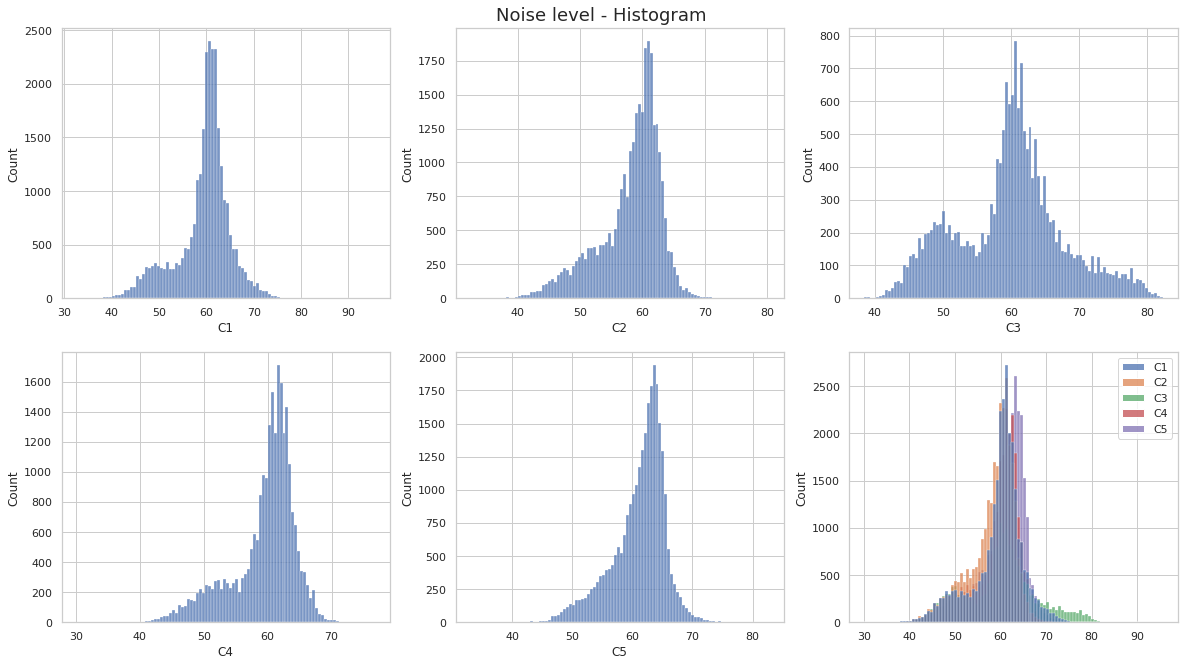

In [73]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
m = 'stack'
fd = {'fontsize': 16}
fd_l = {'fontsize': 12}

axis = [axs[0, 0], axs[0, 1], axs[0, 2], axs[1, 0], axs[1, 1], axs[1, 2]]

for i in range(6):    
    if i==5:
        sns.histplot(df[sensors], ax=axis[i],bins=100, multiple=m)
    else:
        sns.histplot(df[sensors[i]], ax=axis[i], bins=100, multiple=m)

fig.suptitle("Noise level - Histogram", size=18)
fig.subplots_adjust(top=0.95)

## Plotting Data

Text(0.5, 0.9, 'Noise Level')

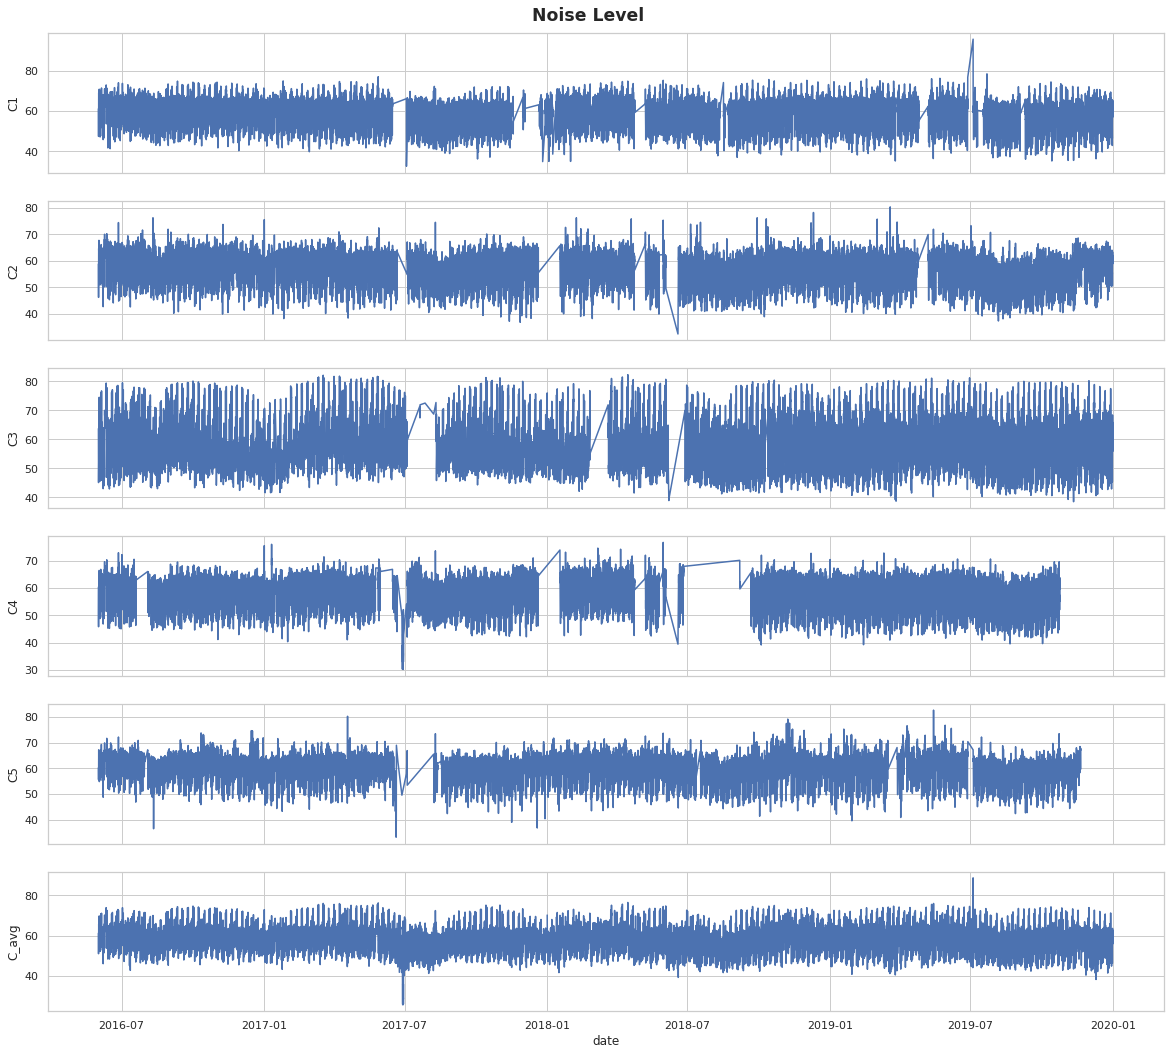

In [74]:
fig, axs = plt.subplots(6, 1, sharex=True, figsize=(20, 18))
sns.lineplot(data=df.C1, ax=axs[0])
sns.lineplot(data=df.C2, ax=axs[1])
sns.lineplot(data=df.C3, ax=axs[2])
sns.lineplot(data=df.C4, ax=axs[3])
sns.lineplot(data=df.C5, ax=axs[4])
sns.lineplot(data=df.C_avg, ax=axs[5])

fig.suptitle("Noise Level", fontsize='x-large', fontweight='bold', y=.9)

# Exploratory Data Analysis

## Autocorrelation Plot

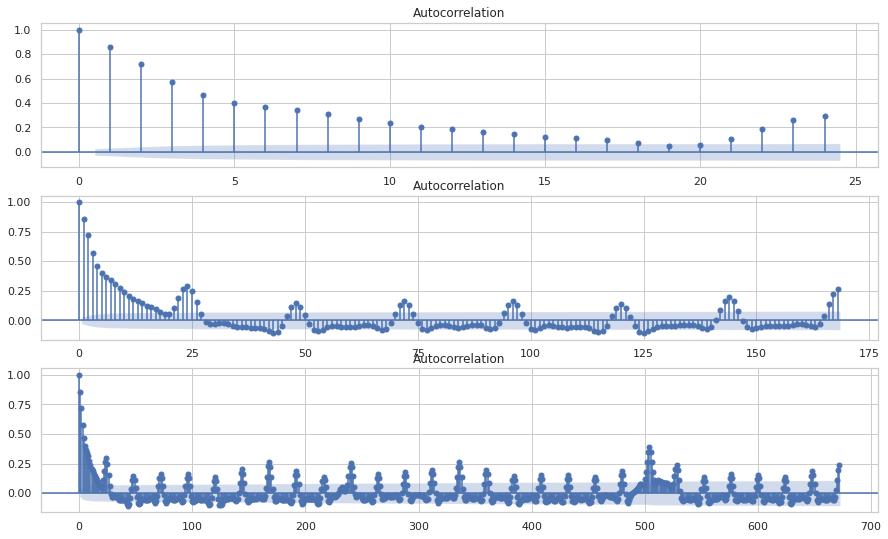

In [75]:
def autocorrelation(df, ps):
    
    df = df.fillna(0)
    
    fig, ax = plt.subplots(len(ps), 1, figsize=(15, 3*len(ps)))
    for i in range(len(ps)):
        plot_acf(df.tolist(), lags=ps[i], ax=ax[i])
        
autocorrelation(df[(df.year==2016)].C1, [24, 24*7, 24*7*4])

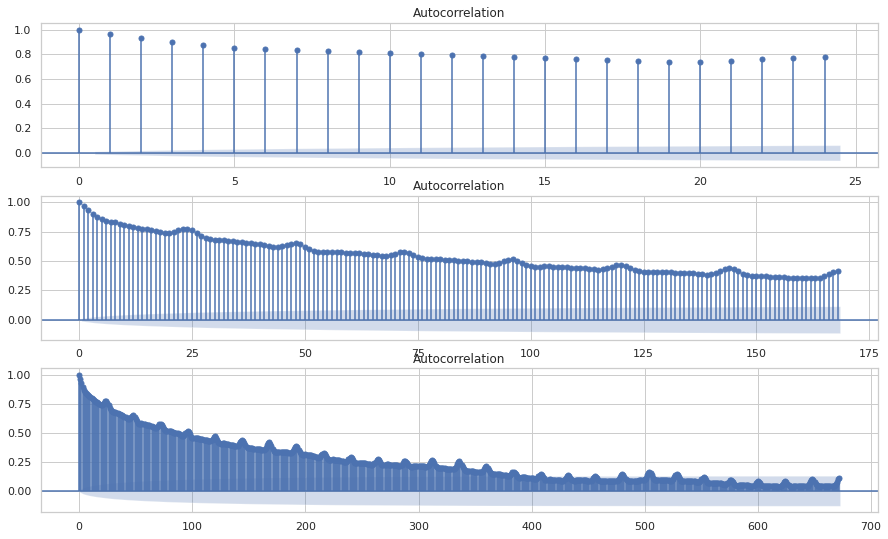

In [76]:
autocorrelation(df.C1, [24, 24*7, 24*7*4])

## Seasonal decompose

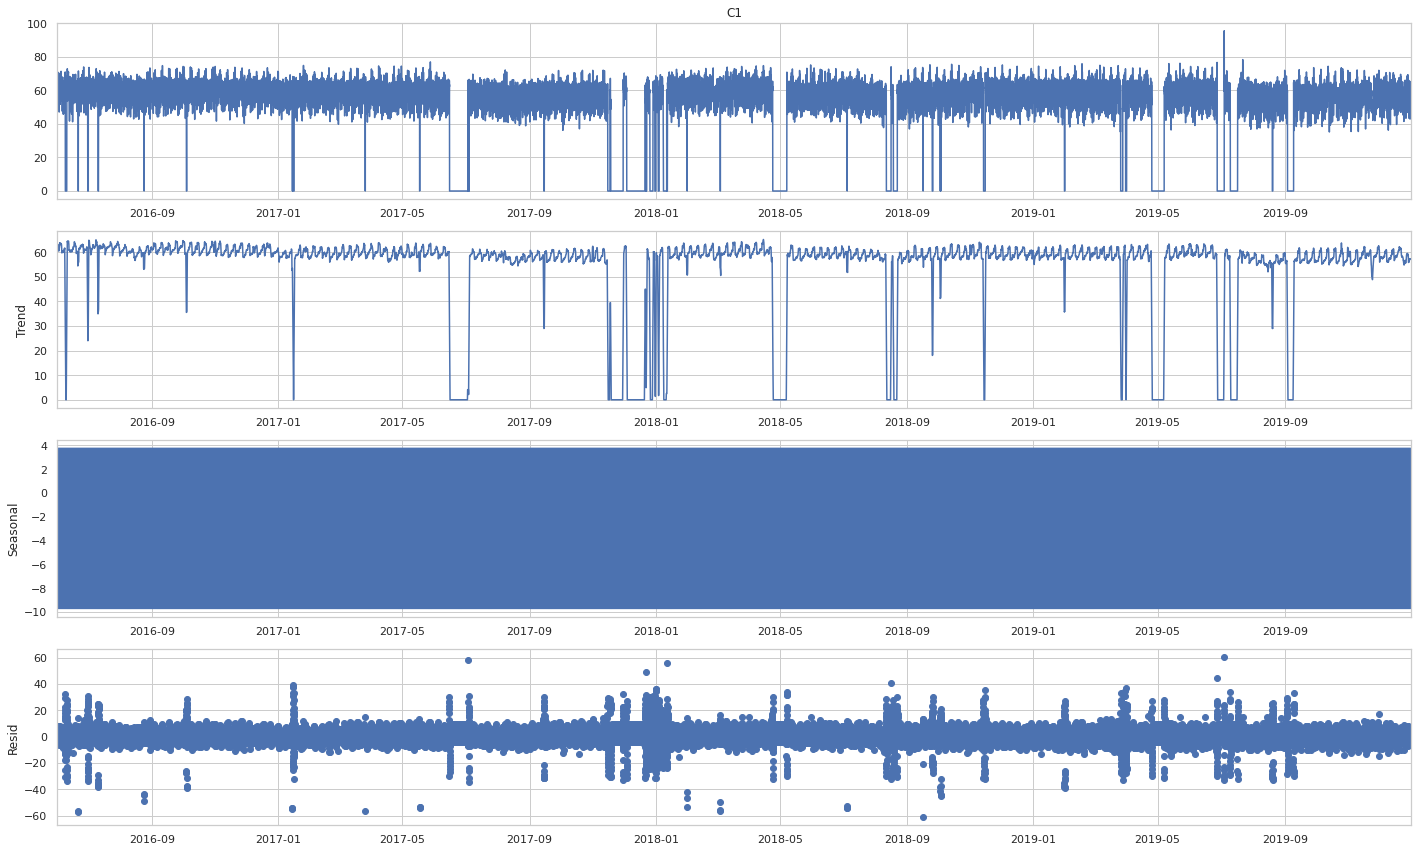

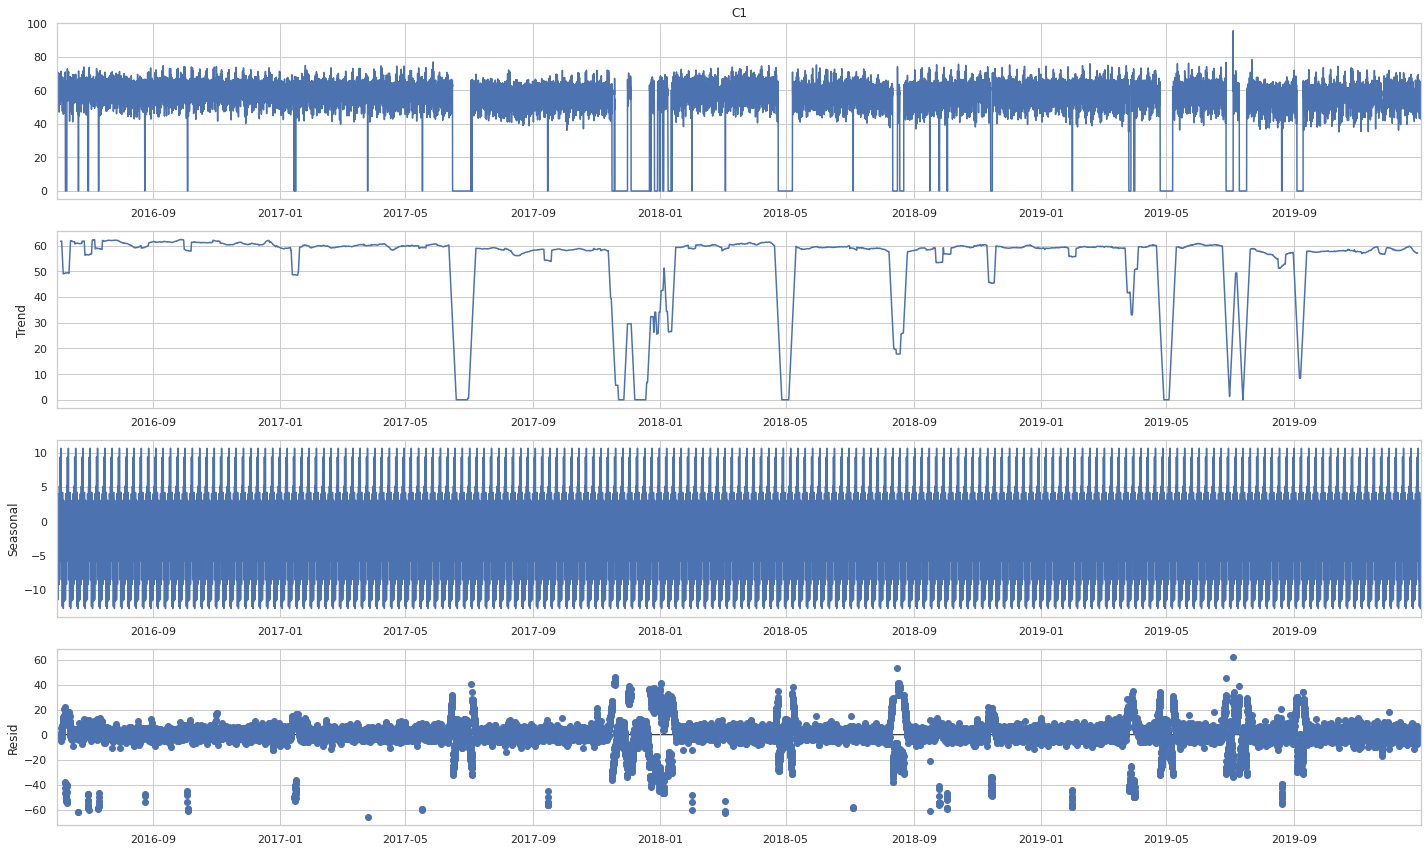

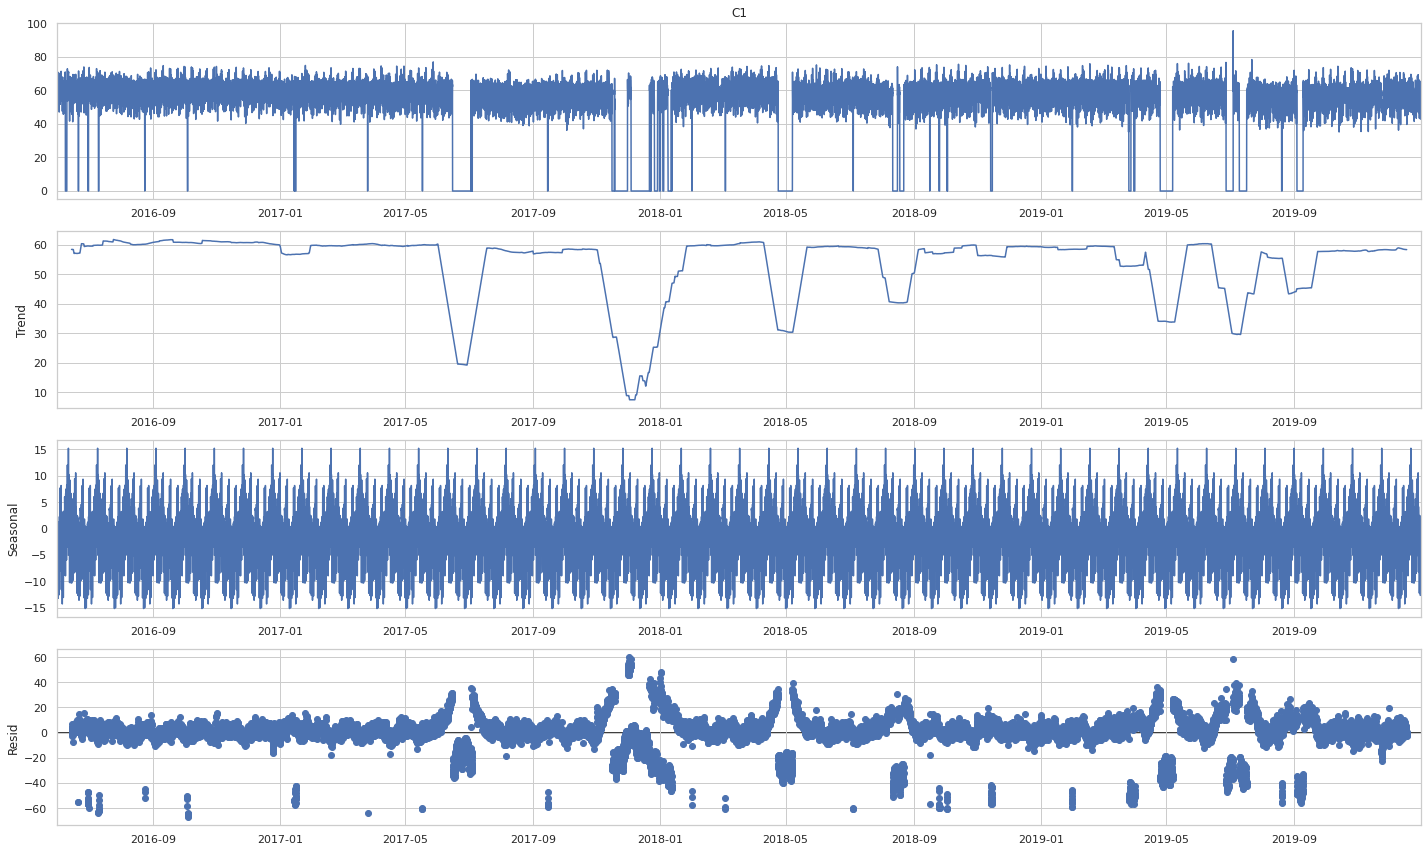

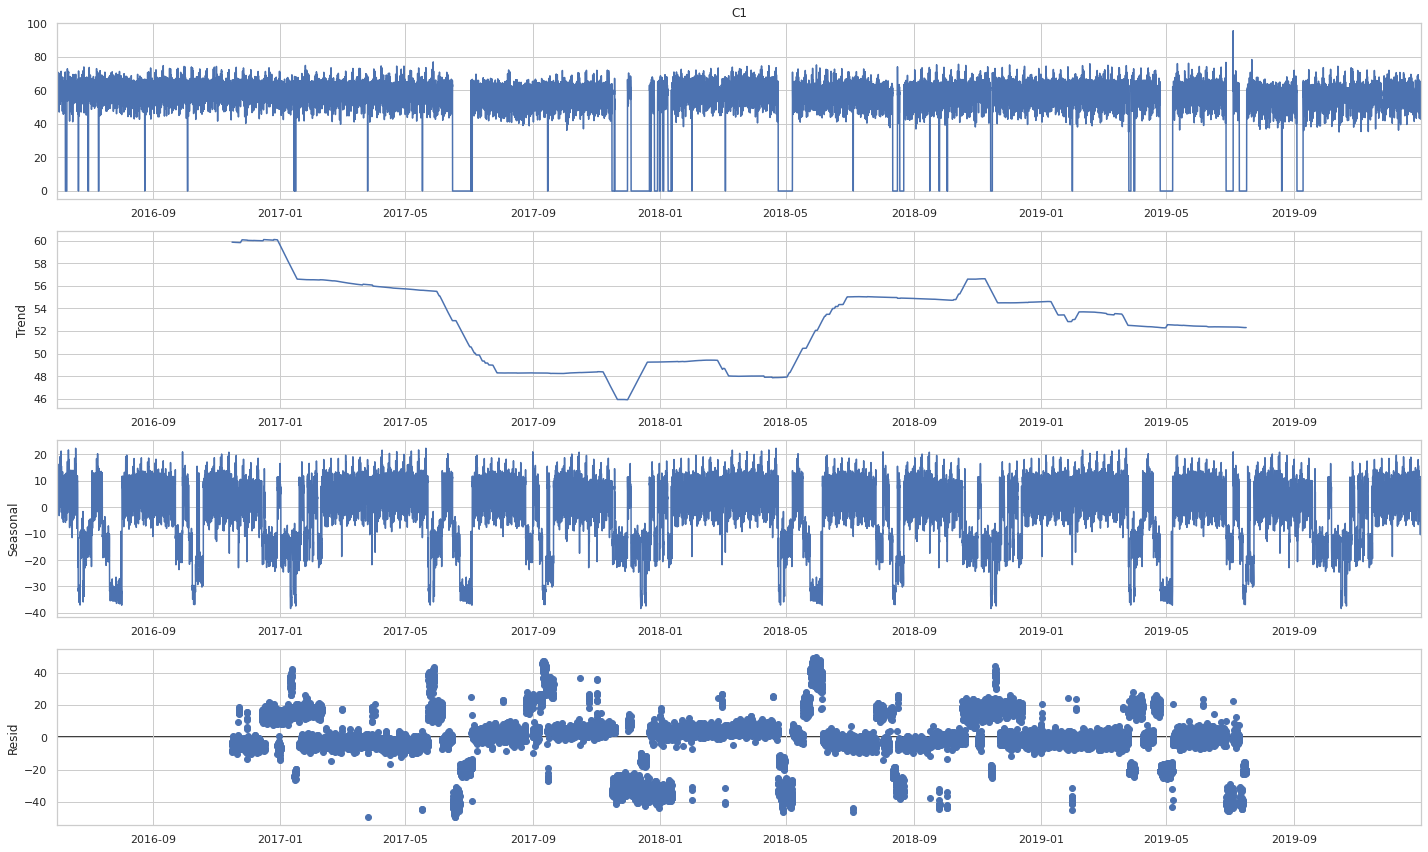

In [77]:
def ts_seasonal_decompose(df, ps):
    
    df = df.fillna(0)

    for p in ps:
        decomposition = seasonal_decompose(df, model='additive', period=p)
        decomposition.plot()
        
ts_seasonal_decompose(df.C1, [24, 24*7, 24*7*4, 24*7*4*12])

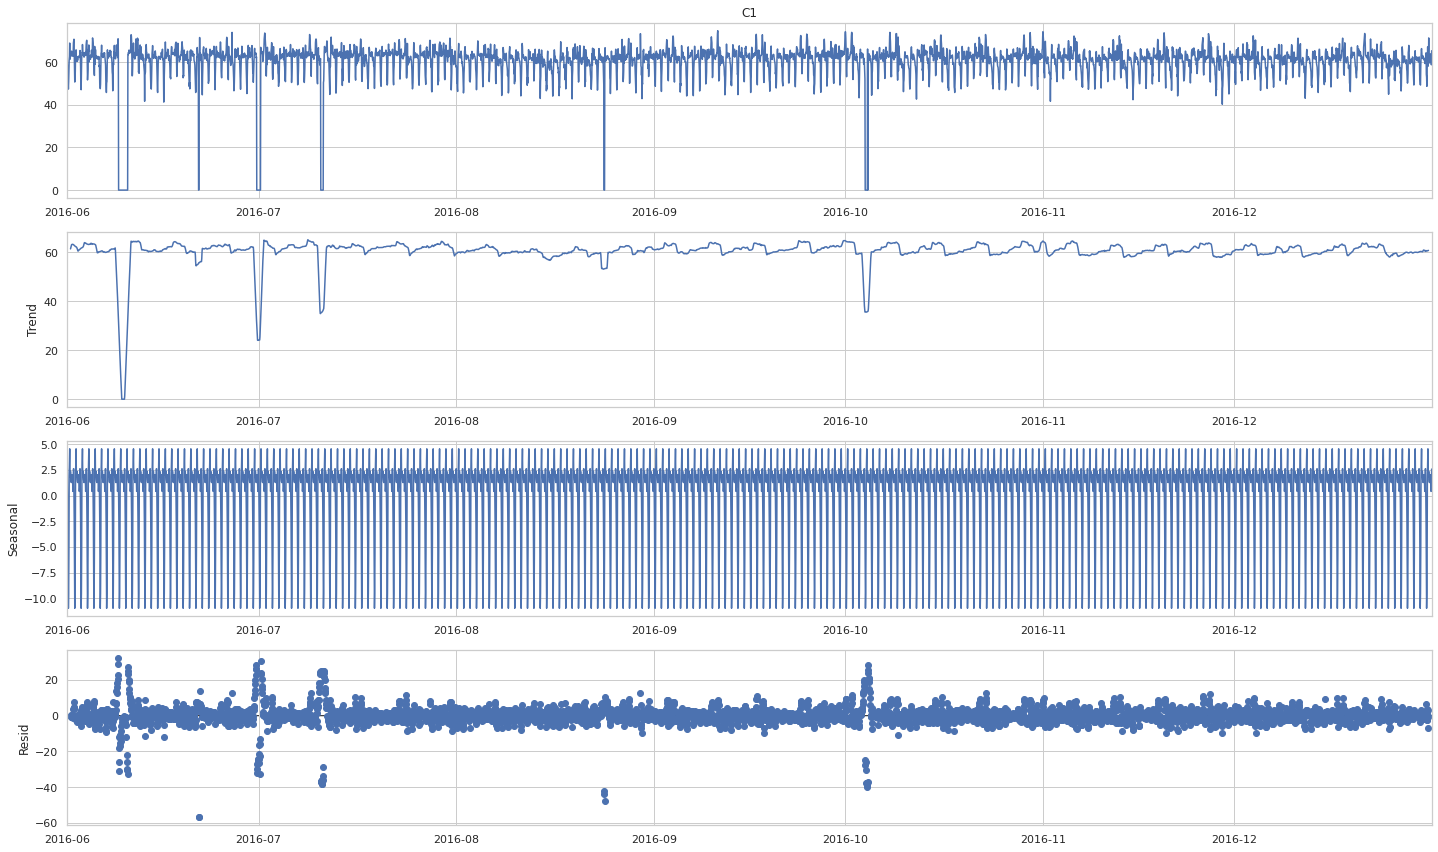

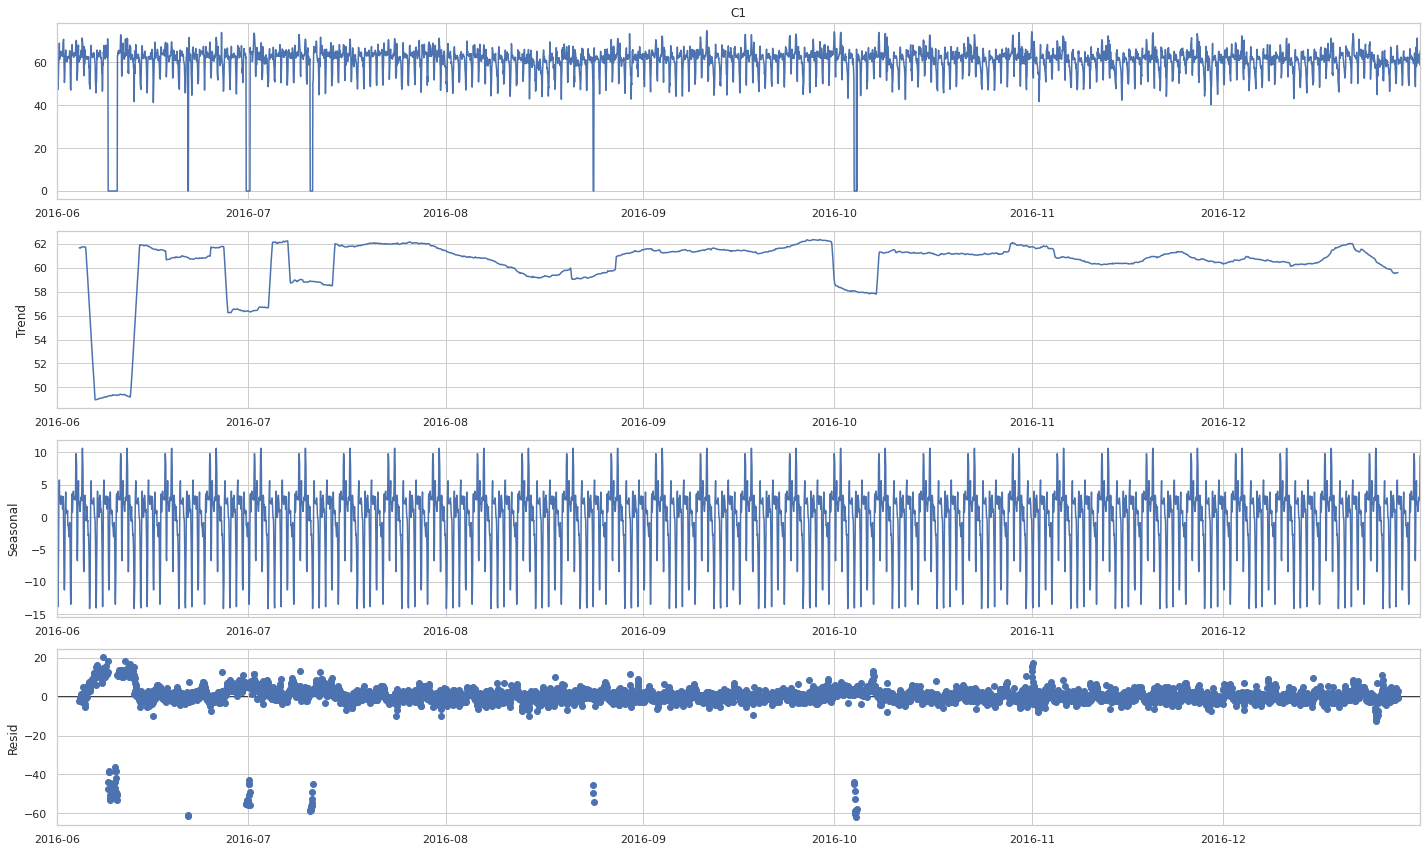

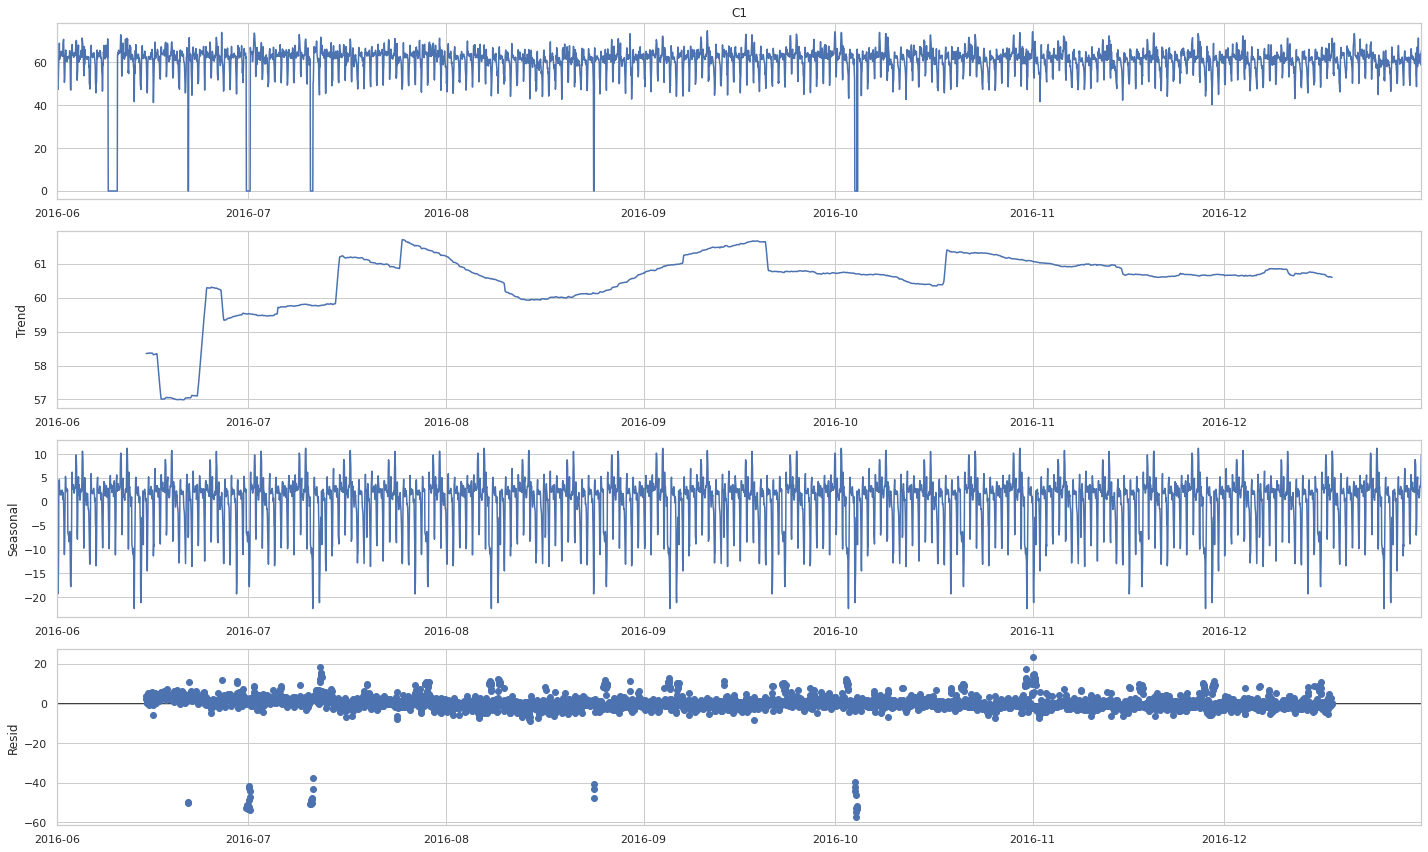

In [78]:
ts_seasonal_decompose(df[df.year==2016].C1, [24, 24*7, 24*7*4])

## Correlation between variables

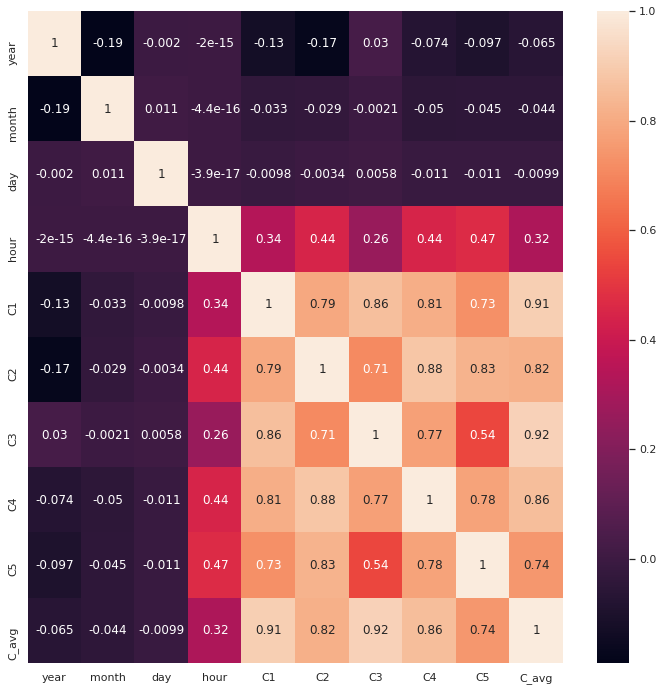

In [79]:
correlation_matrix(df)

Additive decomposition since our data has 0's.

# Another chapter

# Medidas de combate ao barulho

- meter a polícia a fazer patrulhas/organização
- meter capacidades máximas de pessoas em locais

# Conclusions

## Scalability and Impact

## Future Work

# References